In [147]:
import pandas as pd
import re

#df = pd.read_csv('/Users/jkgerdts/Google Drive/LAB/data/2021 05-30 KTrail CD19 pilot 24 hrs/flowjodata.csv')
#layout = pd.read_csv('/Users/jkgerdts/Google Drive/LAB/data/2021 05-30 KTrail CD19 pilot 24 hrs/platemap.csv')

class counter:
    # a basic counter object
    def __init__(self):
        self.count=0
    def addone(self):
        self.count = self.count+1
        
class bag:
    # an object holding multiple counters with methods to randomly distribute a defined number of counts among the counters
    import numpy as np
    def __init__(self,n=1):
        self.counters=[counter() for x in range(n)]
    def add(self,n):
        for c in np.random.choice(self.counters,n):
            c.addone()
    def getnpos(self):
        return sum([c.count>0 for c in self.counters])/len(self.counters)*100

def makeMOIcurve(n,vcount):
    # uses counter/bag objects to model MOI in a population for an array of virus particle counts
    frxp = []
    for vc in vcount:
        cc=bag(n)
        cc.add(vc)
        frxp.append(cc.getnpos())
    return frxp

def reorgFlowData(flowdatacsv,layoutcsv,mindepth=3):

    layout = pd.read_csv(layoutcsv)
    df = pd.read_csv(flowdatacsv)
    
    wellstrparser = re.compile('([A-Q][0-9]{2})_[0-9]{3}')
    wellstr2wellnbr = lambda wellstr: {'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7}[wellstr[0]]*12+int(wellstr[1:])
    wellstr2row = lambda wellstr: wellstr[0]
    wellstr2col = lambda wellstr: int(wellstr[1:])
    getwellstr = lambda name: re.findall(wellstrparser,name)[0]
    def getlastgroup(name):
        groupsparser = re.compile('/([A-Za-z0-9-+\s_]+)')
        groups = re.findall(groupsparser,name)
        if len(groups)<1:
            return ''
        else:
            return groups[-1]

    df['row']=[wellstr2row(getwellstr(x)) for x in df['Name']]
    df['col']=[wellstr2col(getwellstr(x)) for x in df['Name']]
    df['w']=[wellstr2wellnbr(getwellstr(x)) for x in df['Name']]
    df['lastgroup']=[getlastgroup(x) for x in df['Name']]
    df['Depth']=[sum([x in ['>'] for x in str(y)]) for y in df['Depth'].values] 
        # reassigns depth string column to integers ("> > > " becomes 3 etc)
    df = df.merge(layout,on='w',how='inner')

    df= df[df['Depth']>=mindepth]
    
    return df
    
    
    ################################################
    #dfg = df.groupby(['jurkats','lastgroup']).agg({'Statistic':['mean','sem'],'#Cells':['mean','sem']})
    #dfg.loc[(slice('Ktrail','Ktrail19'),slice(None),slice('Q3_J101_farred','Q4_J_ctrl'),slice(None)),:]

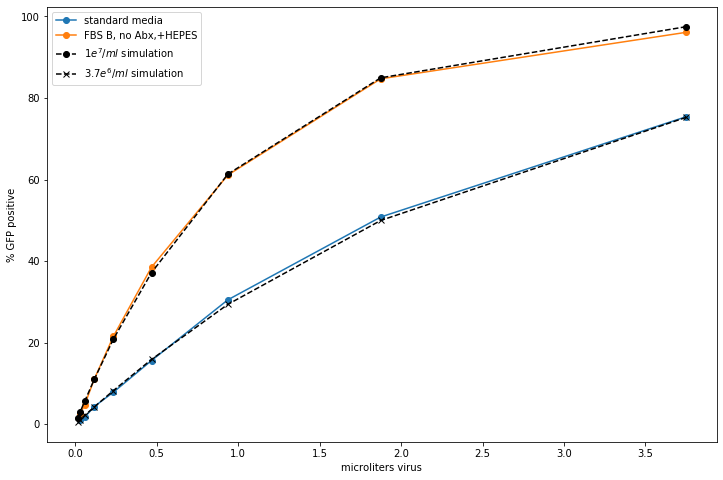

In [281]:
df = reorgFlowData(
    '/Volumes/HooToo/2021 06-04 LV titers/data.csv',
    '/Volumes/HooToo/2021 06-04 LV titers/layout.csv')
df = df.set_index(['var_2'])
df = df[df['var_1']<7]
f,ax = plt.subplots(figsize=[12,8])
labels = {'A':'standard media','D':'FBS B, no Abx,+HEPES'}
for virus in ['A','D']:
    df[df['var_1']>0].loc[virus].plot(x='var_1',y='Statistic',ax=ax,marker='o',label=labels[virus])
    #plt.xscale('log')
    
ax.set_xlabel('microliters virus')
ax.set_ylabel('% GFP positive')
#plt.savefig('/Volumes/HooToo/2021 06-04 LV titers/fig.pdf',bbox_inches='tight')
plt.plot([30/2**i for i in range(3,12)],makeMOIcurve(10000,[int(j*10000) for j in [30/2**i for i in range(3,12)]]),linestyle='--',marker='o',color='k',label='$1e^7/ml$ simulation')
plt.plot([30/2**i for i in range(3,12)],makeMOIcurve(10000,[int(j*3700) for j in [30/2**i for i in range(3,12)]]),linestyle='--',marker='x',color='k',label='$3.7e^6/ml$ simulation')
ax.legend()

plt.savefig('/Volumes/HooToo/2021 06-04 LV titers/Plot with simulation.pdf',bbox_inches='tight')
